# Real-time Application Pipeline

In this example, we define an application pipeline that accepts a user request, enriches the request with real-time features from the feature store, and feeds the features into a three-legged ensemble that uses the newly trained models.

You would typically need to implement and deploy multiple microservices and com‐ plex logic to build such an application pipeline. But, with MLRun, you can define it in a few lines of code and deploy it automatically into elastic serverless functions. In addition, the MLRun serving framework will automatically support real-time feature imputing, model monitoring, and so on without requiring extra coding.

In [1]:
import mlrun
project = mlrun.load_project(
    name="fraud-demo",
    context="./",
    user_project=True,
    )

## Defining a custom serving class

MLRun has many built-in model-serving classes for different frameworks (Sklearn, Xgboost, PyTorch, TensorFlow, ONNX, Hugging Face models, and so on). You can also build your custom model serving class as demonstrated in Example 7-24. The serving class must support the load() method for loading the model and the predict() method for making a prediction. You can read MLRun documentation to see all the hooks and advanced usage.

In [2]:
# mlrun: start-code

In [3]:
import numpy as np
from cloudpickle import load
from mlrun.serving.v2_serving import V2ModelServer

class ClassifierModel(V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        print(f"Input -> {body['inputs']}")
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [4]:
# mlrun: end-code

## Building an Application Pipeline with Enrichment and Ensemble

MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files. The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere. Nuclio is a high-performance open-source serverless framework focused on data, I/O, and compute-intensive workloads.

The EnrichmentVotingEnsemble router class auto-enriches the request with data from the feature store. The router input accepts a list of inference requests (each request can be a dict or list of incoming features/keys). It enriches the request with data from the specified feature vector (feature_vector_uri), forwards the vector to one or more models in an ensemble, and returns an aggregated prediction value (for example, the average result across the three models).
The features can often have null values (None, NaN, Inf). The Enrichment_ routers can substitute the null value with fixed or statistical value per fea ture. This is done through the `impute_policy` parameter, which accepts the impute policy per feature (where * is used to specify the default). The value can be a fixed number for constants or $mean, $max, $min, $std, $count for statistical values to substitute the value with the equivalent feature stats (taken from the feature store).
The code in Example 7-24 defines a new serving function with the ClassifierModel class code (in serving.py) and a router topology (using the EnrichmentVotingEnsem ble router class) with three child models.

In [5]:
[(m.spec.db_key, m.metadata.to_dict()) for m in project.list_models('', tag='latest')]

[('transaction_fraud_xgboost',
  {'iter': 2,
   'tag': 'latest',
   'labels': {'workflow-id': '3711f82e5fc54517a0ced56e1eb3b965',
    'framework': 'sklearn'},
   'tree': '3711f82e5fc54517a0ced56e1eb3b965',
   'uid': 'a3a61f9ade2fde3bc21d7f4e5df994c97c8cfd65',
   'updated': '2025-01-28 19:20:09.040778+00:00',
   'key': 'model',
   'hash': '0d5c54e2f5b0b046fcfb0a1b9fbcee72297c3b20',
   'project': 'fraud-demo-jovyan'}),
 ('transaction_fraud_adaboost',
  {'iter': 3,
   'tag': 'latest',
   'labels': {'workflow-id': '3711f82e5fc54517a0ced56e1eb3b965',
    'framework': 'sklearn'},
   'tree': '3711f82e5fc54517a0ced56e1eb3b965',
   'uid': 'becbf22a706dd6e38276834326d058d7b38e8371',
   'updated': '2025-01-28 19:20:07.459189+00:00',
   'key': 'model',
   'hash': '4eb1464f9c67926bc264350d1ebf66e8c64dfa83',
   'project': 'fraud-demo-jovyan'}),
 ('transaction_fraud_rf',
  {'iter': 1,
   'tag': 'latest',
   'labels': {'workflow-id': '3711f82e5fc54517a0ced56e1eb3b965',
    'framework': 'sklearn'},
   

store://models/fraud-demo-jovyan/transaction_fraud_xgboost#2:latest@3711f82e5fc54517a0ced56e1eb3b965^a3a61f9ade2fde3bc21d7f4e5df994c97c8cfd65
store://models/fraud-demo-jovyan/transaction_fraud_adaboost#3:latest@3711f82e5fc54517a0ced56e1eb3b965^becbf22a706dd6e38276834326d058d7b38e8371
store://models/fraud-demo-jovyan/transaction_fraud_rf#1:latest@3711f82e5fc54517a0ced56e1eb3b965^7115d0f7c9a0e032af3e43d27678ef0f6a7f9477


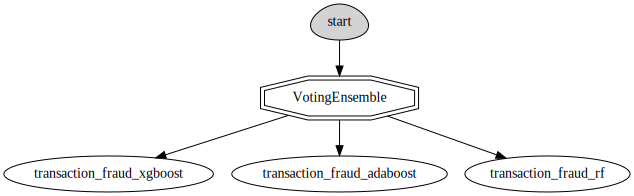

In [6]:
# Create the serving function from your code above
serving_fn = project.set_function('src/serving.py', name='test-function',
                                  image="mlrun/mlrun", kind="serving")
serving_fn.set_topology(
    "router",
    mlrun.serving.routers.EnrichmentVotingEnsemble(
        feature_vector_uri="short",
        impute_policy={"*": "$mean"}),
)
# add the 3 trained models to the Ensemble
for model in project.list_models('', tag='latest'):
    name = model.spec.db_key
    print(model.uri)
    serving_fn.add_model(name, class_name="ClassifierModel", model_path=model.uri)
# Plot the ensemble configuration
serving_fn.spec.graph.plot()

## Test the Application Pipeline Locally

Before deploying the serving function, you can test it in the current notebook and check the model output.

In [7]:
# Create a mock server from the serving function
local_server = serving_fn.to_mock_server()

> 2025-01-28 19:28:05,071 [info] model transaction_fraud_xgboost was loaded
> 2025-01-28 19:28:05,121 [info] model transaction_fraud_adaboost was loaded
> 2025-01-28 19:28:05,138 [info] model transaction_fraud_rf was loaded


In [8]:
# Choose an id for your test
sample_id = 'C1000148617'

# Send your sample ID for prediction
local_server.test(path='/v2/models/infer',
            body={'inputs': [[sample_id]]})

# notice the input vector is printed 3 times (once per child model) and is enriched with data from the feature store

Input -> [[60.98, 73.78999999999999, 2.0, 36.894999999999996, 134.16, 967.0900000000001, 30.0, 32.23633333333334, 143.87, 1835.7000000000003, 58.0, 31.650000000000006, 90.0, 1.0, 2.0, 4.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0]]
Input -> [[60.98, 73.78999999999999, 2.0, 36.894999999999996, 134.16, 967.0900000000001, 30.0, 32.23633333333334, 143.87, 1835.7000000000003, 58.0, 31.650000000000006, 90.0, 1.0, 2.0, 4.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0]]
Input -> [[60.98, 73.78999999999999, 2.0, 36.894999999999996, 134.16, 967.0900000000001, 30.0, 32.23633333333334, 143.87, 1835.7000000000003, 58.0, 31.650000000000006, 90.0, 1.0, 2.0, 4.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0]]


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


{'id': '52f2c72c7c2642e2a9ca48cd7997500a',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

### Accessing the real-time feature vector directly

If you would like to access the real-time features directly from your application instead of using the EnrichmentVotingEnsemble, you can call the feature store `get_online_feature_service()` method. This method is used internally in the EnrichmentVotingEnsemble router class.

In [9]:
import mlrun.feature_store as fs

# Create the online feature service
svc = fs.get_feature_vector('short:latest').get_online_feature_service(impute_policy={"*": "$mean"})

# Get sample feature vector
sample_fv = svc.get([{'source': sample_id}])
sample_fv

[{'amount_max_2h': 60.98,
  'amount_max_12h': 134.16,
  'amount_max_24h': 143.87,
  'amount_count_2h': 2.0,
  'amount_count_12h': 30.0,
  'amount_count_24h': 58.0,
  'amount_sum_2h': 73.78999999999999,
  'amount_sum_12h': 967.0900000000001,
  'amount_sum_24h': 1835.7000000000003,
  'es_transportation_sum_14d': 90.0,
  'es_health_sum_14d': 1.0,
  'es_otherservices_sum_14d': 2.0,
  'es_food_sum_14d': 4.0,
  'es_hotelservices_sum_14d': 0.0,
  'es_barsandrestaurants_sum_14d': 0.0,
  'es_tech_sum_14d': 1.0,
  'es_sportsandtoys_sum_14d': 1.0,
  'es_wellnessandbeauty_sum_14d': 2.0,
  'es_hyper_sum_14d': 1.0,
  'amount_avg_2h': 36.894999999999996,
  'amount_avg_12h': 32.23633333333334,
  'amount_avg_24h': 31.650000000000006}]

## Deploying the function on the Kubernetes cluster

You can now deploy the function. Once deployed, you get a function with http trigger that can be called from other locations.

In [10]:
# On community edition, set Redis credentials.

import os

redis_host = os.getenv("REDIS_MASTER_SERVICE_HOST", None)
redis_port = int(os.getenv("REDIS_REPLICAS_SERVICE_PORT", None))

assert redis_host and redis_port, "Redis Host and Port must be provided "

redis_uri = f"redis://{redis_host}:{redis_port}" 
print(redis_uri)
if mlrun.mlconf.is_ce_mode():
    serving_fn.set_envs({'REDIS_URI': redis_uri})

redis://10.43.31.185:6379


In [11]:
# Enable model monitoring
# serving_fn.set_tracking()

# Deploy the serving function
serving_fn.deploy()

> 2025-01-28 19:28:14,895 [warning] It is recommended to use k8s secret (specify secret_name), specifying aws_access_key/aws_secret_key directly is unsafe.
> 2025-01-28 19:28:14,898 [info] Starting remote function deploy
2025-01-28 19:28:15  (info) Deploying function
2025-01-28 19:28:15  (info) Building
2025-01-28 19:28:15  (info) Staging files and preparing base images
2025-01-28 19:28:15  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-01-28 19:28:15  (info) Building processor image
2025-01-28 19:31:50  (info) Build complete
2025-01-28 19:32:04  (info) Function deploy complete
> 2025-01-28 19:32:07,101 [info] Model endpoint creation task completed with state succeeded
> 2025-01-28 19:32:07,102 [info] Successfully deployed function: {"external_invocation_urls":["localhost:30680"],"internal_invocation_urls":["nuclio-fraud-demo-jovyan-test-function.mlrun.svc.cluster.local:8080"]}


'http://localhost:30680'

## Test the server

You can test the serving function and examine the model output.

In [13]:
# Choose an id for your test
sample_id = 'C1000148617'

model_inference_path = '/v2/models/infer'

# Send your sample ID for prediction
serving_fn.invoke(path='/v2/models/infer',
                  body={'inputs': [[sample_id]]})

> 2025-01-28 19:32:41,187 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-jovyan-test-function.mlrun.svc.cluster.local:8080/v2/models/infer"}


{'id': 'efeb1f99-2cef-49bb-a960-a8f13ac9695e',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

You can also directly query the feature store values, which are used in the enrichment.

### Simulate incoming data

In [14]:
# Load the dataset
data = mlrun.get_dataitem(mlrun.get_sample_path("data/fraud-demo-mlrun-fs-docs/data.csv")).as_df()

# use only first 10k
data = data.sort_values(by='source', axis=0)[:10000]

# keys
sample_ids = data['source'].to_list()

In [15]:
from random import choice, uniform
from time import sleep

# Sending random requests
for _ in range(10):
    data_point = choice(sample_ids)
    try:
        resp = serving_fn.invoke(path=model_inference_path, body={'inputs': [[data_point]]})
        print(resp)
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass

> 2025-01-28 19:33:43,110 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-jovyan-test-function.mlrun.svc.cluster.local:8080/v2/models/infer"}
{'id': 'd798a060-769d-428c-80d7-7cd07b58cba9', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2025-01-28 19:33:44,715 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-jovyan-test-function.mlrun.svc.cluster.local:8080/v2/models/infer"}
{'id': 'c01da731-c349-40f1-91cf-cae9c7bfe9da', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2025-01-28 19:33:45,705 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-jovyan-test-function.mlrun.svc.cluster.local:8080/v2/models/infer"}
{'id': '7e70ef66-1d4a-4190-aeeb-f7979790397c', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2025-01-28 19:33:46,695 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-jovyan-test-function.mlrun.svc.clu

## Done!

You've completed the fraud-detection demo. 
